In [3]:
import glob
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from PIL import Image

In [4]:
data_dir = 'chest_xray/'
test_dir = data_dir + 'test/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'

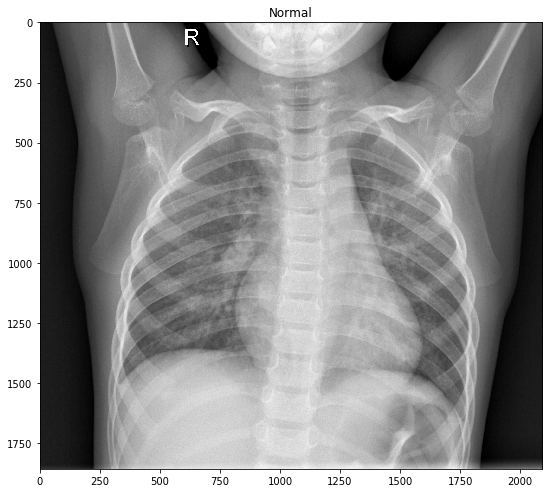

In [3]:
# Normal sample
img_normal = cv2.imread(train_dir+'NORMAL/'+'IM-0115-0001.jpeg')
plt.figure(figsize=(9,9))
plt.title('Normal')
plt.imshow(img_normal,cmap='gray')

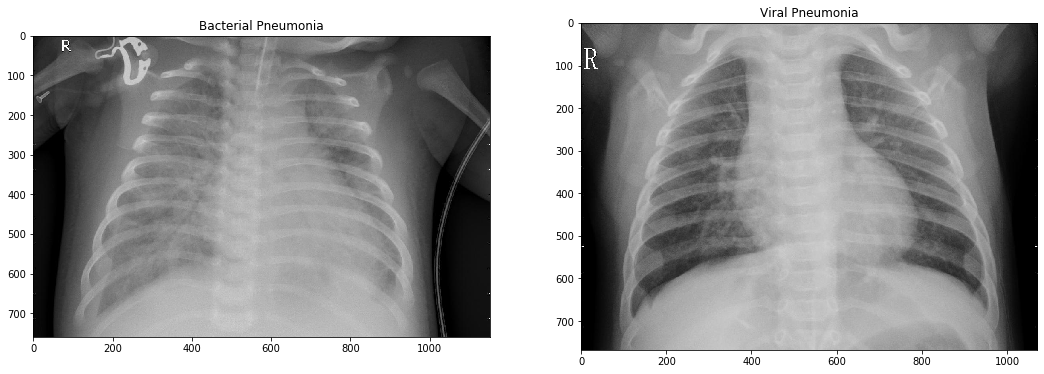

In [4]:
# PNEUMONIA samples
img_bacterial = cv2.imread(train_dir+'PNEUMONIA/'+'person1000_bacteria_2931.jpeg')
img_viral = cv2.imread(train_dir+'PNEUMONIA/'+'person1000_virus_1681.jpeg')
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.title('Bacterial Pneumonia')
plt.imshow(img_bacterial,cmap='gray')
plt.subplot(1,2,2)
plt.title('Viral Pneumonia')
plt.imshow(img_viral,cmap='gray')

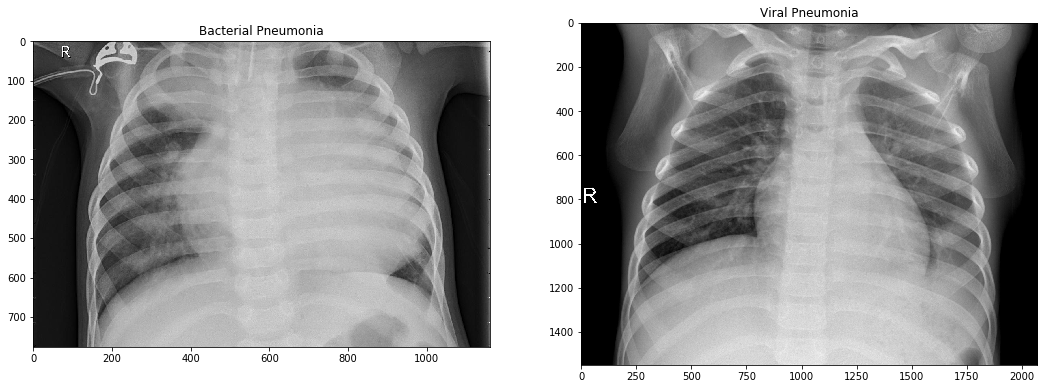

In [8]:
# PNEUMONIA samples
img_bacterial = cv2.imread(train_dir+'PNEUMONIA/'+'person5_bacteria_19.jpeg')
img_viral = cv2.imread(train_dir+'PNEUMONIA/'+'person301_virus_622.jpeg')
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.title('Bacterial Pneumonia')
plt.imshow(img_bacterial,cmap='gray')
plt.subplot(1,2,2)
plt.title('Viral Pneumonia')
plt.imshow(img_viral,cmap='gray')

## Data Analysis, how many samples of each classes do we have?

In [5]:
normal_list = glob.glob(train_dir+'NORMAL/'+'*.jpeg')
desease_list = glob.glob(train_dir+'PNEUMONIA/'+'*.jpeg')

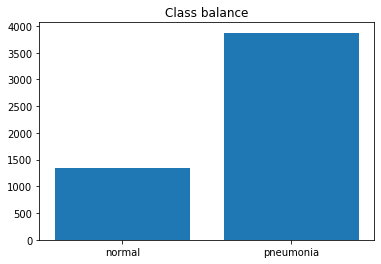

In [6]:
plt.title('Class balance')
plt.bar([0,1],[len(normal_list),len(desease_list)])
plt.xticks([0,1], ('normal', 'pneumonia'))
plt.show()

In [7]:
bacterial_list = [x.split('_')[-2] for x in desease_list if x.split('_')[-2]=='bacteria']
virus_list = [x.split('_')[-2] for x in desease_list if x.split('_')[-2]=='virus']

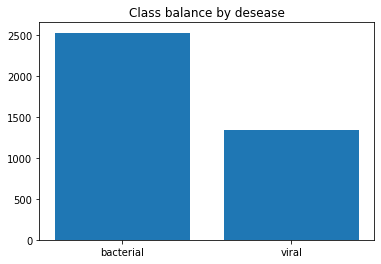

In [8]:
plt.title('Class balance by desease')
plt.bar([0,1],[len(bacterial_list),len(virus_list)])
plt.xticks([0,1], ('bacterial', 'viral'))
plt.show()

## Data augmentation

In [9]:
import imgaug as ia
import imgaug.augmenters as iaa
import numpy
numpy.random.bit_generator = numpy.random._bit_generator

In [10]:
seq = iaa.OneOf([iaa.Fliplr(), iaa.Affine(rotate=20), iaa.Multiply((1.2, 1.5))])

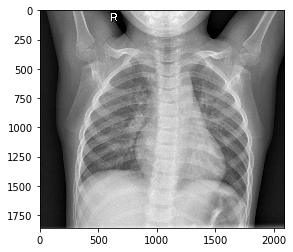

In [11]:
plt.imshow(img_normal,cmap='gray')

In [12]:
img_normal.shape

(1858, 2090, 3)

In [13]:
img_aug = seq(images=[img_normal])

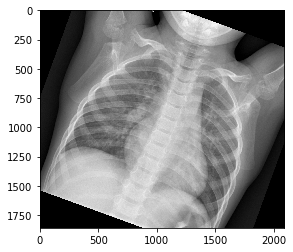

In [14]:
plt.imshow(img_aug[0],cmap='gray')

In [15]:
data = pd.DataFrame(columns=['image', 'label'])
data['image'] = normal_list + desease_list

In [16]:
data['label'] = data['image'].apply(lambda x: 0 if x.split('/')[-2]=='NORMAL' else 1)
data.head()

,image,label
0,chest_xray/train/NORMAL/IM-0464-0001.jpeg,0
1,chest_xray/train/NORMAL/IM-0636-0001.jpeg,0
2,chest_xray/train/NORMAL/NORMAL2-IM-1335-0001.jpeg,0
3,chest_xray/train/NORMAL/IM-0535-0001.jpeg,0
4,chest_xray/train/NORMAL/NORMAL2-IM-1035-0001.jpeg,0


In [17]:
data.shape

(5216, 2)

# Load model

## EfficientNet https://arxiv.org/pdf/1905.11946.pdf

In [18]:
import keras
import efficientnet.keras as efn 

from keras.models import Model, load_model
from keras.layers import Dense, Flatten
from keras import backend as K

import imgaug as ia
import imgaug.augmenters as iaa

import glob
import cv2

import numpy
import pandas as pd

numpy.random.bit_generator = numpy.random._bit_generator

In [19]:
IMG_HEIGHT = 240
IMG_WIDTH = 240

In [20]:
from keras.models import load_model
model = load_model('efficientNet_240_240_demo')












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 120, 120, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 120, 120, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 120, 120, 32) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

# Test

In [22]:
test_normal_list = glob.glob(test_dir+'NORMAL/'+'*.jpeg')
test_desease_list = glob.glob(test_dir+'PNEUMONIA/'+'*.jpeg')

test = pd.DataFrame(columns=['image', 'label'])
test['image'] = test_normal_list + test_desease_list

test['label'] = test['image'].apply(lambda x: 0 if x.split('/')[-2]=='NORMAL' else 1)
test = test.sample(frac=1.).reset_index(drop=True)

test.head()

,image,label
0,chest_xray/test/PNEUMONIA/person78_bacteria_38...,1
1,chest_xray/test/PNEUMONIA/person139_bacteria_6...,1
2,chest_xray/test/NORMAL/IM-0037-0001.jpeg,0
3,chest_xray/test/PNEUMONIA/person146_bacteria_7...,1
4,chest_xray/test/PNEUMONIA/person139_bacteria_6...,1


In [110]:
print(f'The number of pacients from test set: {test.shape[0]}')
print(f'People with Pneumonia: {test[test.label==1].shape[0]}')
print(f'Normal people: {test[test.label==0].shape[0]}')

The number of pacients from test set: 624
People with Pneumonia: 390
Normal people: 234


In [130]:
def prediction(im_path):
    im = cv2.imread(im_path)
    im = cv2.resize(im,(240,240))
    im = im/255.
    
    batch = K.expand_dims(im, axis=0)
    r = model.predict(batch,steps=1)
    return r[0][0]

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [31]:
import os

In [25]:
batch_size = 8
steps = test.shape[0]//batch_size

In [49]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size, directory=test_dir,
                                                             shuffle=False, target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                             class_mode='binary')

Found 624 images belonging to 2 classes.


In [52]:
preds = model.predict_generator(test_data_gen, steps, verbose=1)

78/78 [==============================] - 7s 85ms/step


In [98]:
test_data_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [59]:
res = {k:v[0] for k,v in zip(test_data_gen.filenames,preds)}
res

{'NORMAL/IM-0001-0001.jpeg': 0.9971258,
 'NORMAL/IM-0003-0001.jpeg': 0.07612616,
 'NORMAL/IM-0005-0001.jpeg': 0.13710433,
 'NORMAL/IM-0006-0001.jpeg': 0.057105124,
 'NORMAL/IM-0007-0001.jpeg': 0.20905066,
 'NORMAL/IM-0009-0001.jpeg': 0.35587686,
 'NORMAL/IM-0010-0001.jpeg': 0.068888545,
 'NORMAL/IM-0011-0001-0001.jpeg': 0.14899147,
 'NORMAL/IM-0011-0001-0002.jpeg': 0.07400203,
 'NORMAL/IM-0011-0001.jpeg': 0.037802875,
 'NORMAL/IM-0013-0001.jpeg': 0.1681219,
 'NORMAL/IM-0015-0001.jpeg': 0.08099115,
 'NORMAL/IM-0016-0001.jpeg': 0.06665364,
 'NORMAL/IM-0017-0001.jpeg': 0.12563327,
 'NORMAL/IM-0019-0001.jpeg': 0.22566679,
 'NORMAL/IM-0021-0001.jpeg': 0.16336486,
 'NORMAL/IM-0022-0001.jpeg': 0.11101934,
 'NORMAL/IM-0023-0001.jpeg': 0.037926614,
 'NORMAL/IM-0025-0001.jpeg': 0.13672361,
 'NORMAL/IM-0027-0001.jpeg': 0.05649677,
 'NORMAL/IM-0028-0001.jpeg': 0.074329376,
 'NORMAL/IM-0029-0001.jpeg': 0.3532384,
 'NORMAL/IM-0030-0001.jpeg': 0.20487654,
 'NORMAL/IM-0031-0001.jpeg': 0.045080215,
 'N

In [69]:
test['pred'] = test.image.apply(lambda x: res['/'.join(x.split('/')[2:])])

In [82]:
test['pred_binary'] = test['pred']>=.5

In [83]:
test.head()

,image,label,pred,pred_binary
0,chest_xray/test/PNEUMONIA/person78_bacteria_38...,1,0.999986,True
1,chest_xray/test/PNEUMONIA/person139_bacteria_6...,1,0.974332,True
2,chest_xray/test/NORMAL/IM-0037-0001.jpeg,0,0.262583,False
3,chest_xray/test/PNEUMONIA/person146_bacteria_7...,1,0.411694,False
4,chest_xray/test/PNEUMONIA/person139_bacteria_6...,1,0.999998,True


In [84]:
from sklearn import metrics

In [96]:
acc = metrics.accuracy_score(test.label, test.pred_binary)
recall = metrics.recall_score(test.label, test.pred_binary)
precision = metrics.precision_score(test.label, test.pred_binary)

print(f'Accuracy: {acc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

Accuracy: 0.7964743589743589
Recall: 0.9435897435897436
Precision: 0.7780126849894292


In [106]:
(tn, fp), (fn, tp) = metrics.confusion_matrix(test.label, test.pred_binary)
print(f'True negativ: {tn}, False positive: {fp} ')
print(f'False negativ: {fn}, True positive: {tp} ')


True negativ: 129, False positive: 105 
False negativ: 22, True positive: 368 


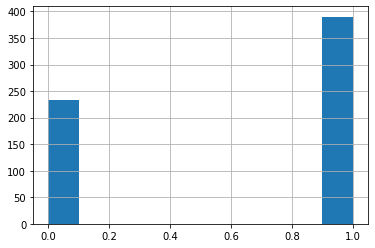

In [100]:
test.label.hist()

## Outcomes for 

- 22 patients will die (5%)
- 368 will be saved
- 105 will be scared but stay alive

In [9]:
22/390

0.05641025641025641